In [1]:
import keras
from keras.datasets import reuters
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Embedding, Dropout, Activation, LSTM, Bidirectional
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools
import collections

Using TensorFlow backend.


## Task 1

### 1.1 - Download dataset

In [2]:
# First we get the whole dataset
(x_tot, y_tot), (_, _) = reuters.load_data(path="reuters.npz",
                                                         num_words=None,
                                                         skip_top=0,
                                                         maxlen=None,
                                                         test_split=0,
                                                         seed=113,
                                                         start_char=1,
                                                         oov_char=2,
                                                         index_from=2)

# Labels in dataset (y_tot) are indexes. From https://github.com/keras-team/keras/issues/12072, we have read the actual strings
classidx =  {'copper': 6, 'livestock': 28, 'gold': 25, 'money-fx': 19, 'ipi': 30, 'trade': 11, 'cocoa': 0, 'iron-steel': 31, 'reserves': 12, 'tin': 26, 'zinc': 37, 'jobs': 34, 'ship': 13, 'cotton': 14, 'alum': 23, 'strategic-metal': 27, 'lead': 45, 'housing': 7, 'meal-feed': 22, 'gnp': 21, 'sugar': 10, 'rubber': 32, 'dlr': 40, 'veg-oil': 2, 'interest': 20, 'crude': 16, 'coffee': 9, 'wheat': 5, 'carcass': 15, 'lei': 35, 'gas': 41, 'nat-gas': 17, 'oilseed': 24, 'orange': 38, 'heat': 33, 'wpi': 43, 'silver': 42, 'cpi': 18, 'earn': 3, 'bop': 36, 'money-supply': 8, 'hog': 44, 'acq': 4, 'pet-chem': 39, 'grain': 1, 'retail': 29}

### 1.2 - Data Analysis

In [3]:
# Number of samples and classes
num_classes = max(y_tot) - min(y_tot) + 1
print('# of Samples: {}'.format(len(x_tot)))
print('# of Classes: {}'.format(num_classes))

# Reverse dictionary to see words instead of integers
# Note that the indices are offset by 3 because 0, 1, and 2 are reserved indices for “padding,” “start of sequence,” and “unknown.”
word_to_wordidx = reuters.get_word_index(path="reuters_word_index.json")
word_to_wordidx = {k:(v+2) for k,v in word_to_wordidx.items()}
word_to_wordidx["<PAD>"] = 0
word_to_wordidx["<START>"] = 1
word_to_wordidx["<UNK>"] = 2
wordidx_to_word = {value:key for key,value in word_to_wordidx.items()}
classidx_to_class = {value:key for key,value in classidx.items()}

# Number of words
print('# of Words (including PAD, START and UNK): {}'.format(len(word_to_wordidx)))

# of Samples: 11228
# of Classes: 46
# of Words (including PAD, START and UNK): 30982


In [4]:
# Now we decode the newswires, using the wordidx_to_word dictionary
def decode_newswire (sample):
    """
    Decodes a Newswire
    
    Arguments:
    sample -- one of the samples in the reuters dataset

    Returns:
    decode_newswire -- a string representing the newswires
    """
    return ' '.join([wordidx_to_word[wordidx] for wordidx in sample])
decoded_newswires = [decode_newswire(sample) for sample in x_tot]

In [5]:
# We print some examples to check if everything is ok
example_num = 1234
print ("ENCODED: ", x_tot[example_num])
print("\nNEWSWIRE: ", decoded_newswires[example_num])
print ("\nCLASS: ", classidx_to_class[y_tot[example_num]])

ENCODED:  [1, 3, 36, 37, 2046, 692, 181, 8, 24, 355, 7, 76, 32, 940, 9, 108, 28, 2013, 4, 194, 2223, 493, 3426, 363, 5, 657, 3, 181, 94, 215, 5, 2841, 1996, 76, 7, 76, 32, 3213, 3, 36, 37, 140, 65, 258, 2929, 1593, 23, 3269, 32, 56, 7225, 4248, 12, 233, 200, 8, 821, 3, 142, 187, 28, 3736, 363, 624, 30, 126, 972, 2087, 51, 1488, 8, 3, 2929, 529, 5235, 194, 489, 20, 3, 167, 641, 4, 24, 3269, 3, 2046, 692, 181, 4, 3, 213, 211, 8, 3, 213, 5550, 355, 7, 6, 240, 23, 1281, 692, 33, 324, 4922, 3, 259, 75, 8, 669, 2938, 61, 833, 5, 2841, 3, 3578, 1259, 489, 22, 5, 2025, 26, 428, 257, 551, 5, 5312, 3, 3426, 363, 16, 11]

NEWSWIRE:  <START> the u s specialty steel industry and its union said they will seek a three year extension of president reagan's import restraint program to give the industry more time to restore competitiveness they said they will tell the u s international trade commission itc thursday that termination will have disastrous consequences for american companies and workers the 

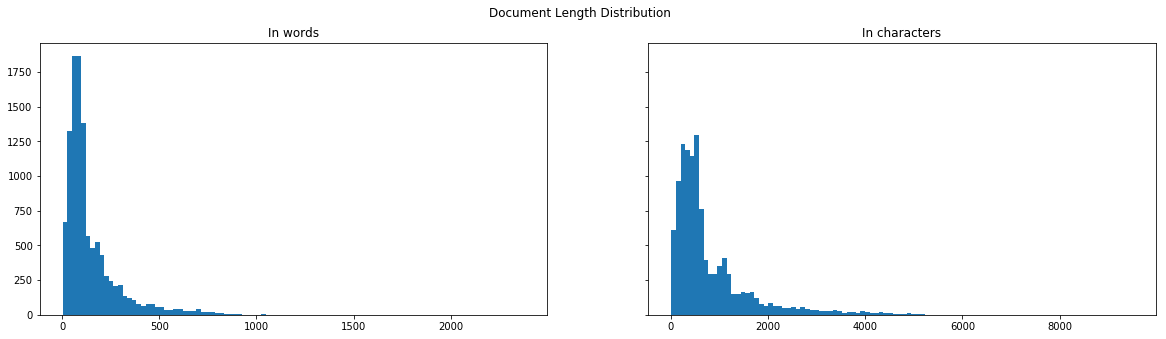

Mean Lenght (in words): 145.96419665122906
Mean Lenght (in characters): 809.6473102956893
Max Lenght (in words): 2376
Max Lenght (in characters): 9499
Min Lenght (in words): 2
Min Lenght (in characters): 10


In [6]:
# We do some statistcs of the length of the documents

documents_word_lenght = [len (sample) for sample in x_tot]
documents_ch_lenght = [len (sample) for sample in decoded_newswires]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.suptitle('Document Length Distribution')
f.set_size_inches((20, 5))
ax1.hist(documents_word_lenght, bins=100)
ax1.set_title('In words')
ax2.hist(documents_ch_lenght, bins=100)
ax2.set_title('In characters')

plt.show()

print('Mean Lenght (in words): {}'.format(np.mean(documents_word_lenght)))
print('Mean Lenght (in characters): {}'.format(np.mean(documents_ch_lenght)))
print('Max Lenght (in words): {}'.format(np.max(documents_word_lenght)))
print('Max Lenght (in characters): {}'.format(np.max(documents_ch_lenght)))
print('Min Lenght (in words): {}'.format(np.min(documents_word_lenght)))
print('Min Lenght (in characters): {}'.format(np.min(documents_ch_lenght)))

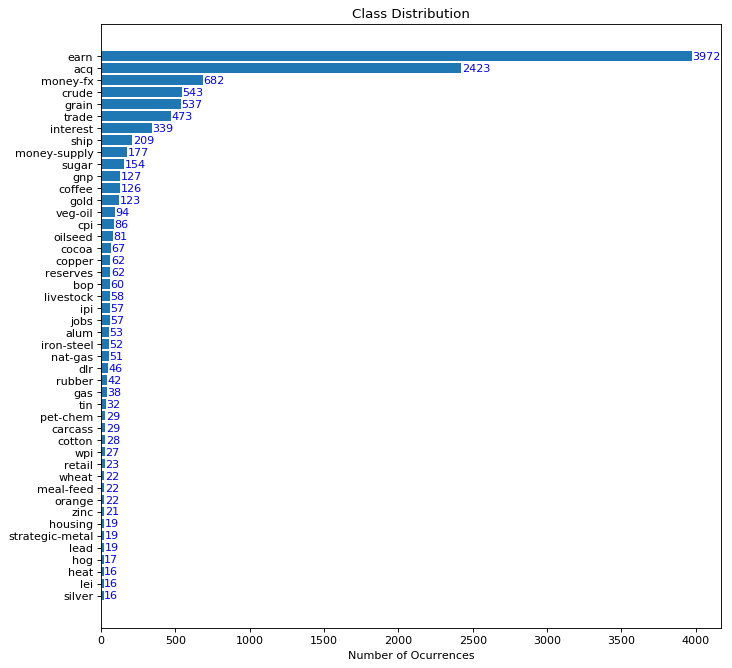

In [7]:
# Class Distribution

y_hist, y_bin_edges =  np.histogram(y_tot, bins=num_classes)

sorted_num_of_ocurrences = np.sort(y_hist)
sorted_classes = [classidx_to_class[key] for key in np.argsort(y_hist)]

plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.barh(sorted_classes, sorted_num_of_ocurrences, align='center')
plt.yticks(np.arange(num_classes), sorted_classes)
plt.xlabel('Number of Ocurrences')
plt.title('Class Distribution')

ax = plt.gca()
for i, v in enumerate(sorted_num_of_ocurrences):
    ax.text(v + 3, i-0.25, str(v), color='blue')

plt.show()

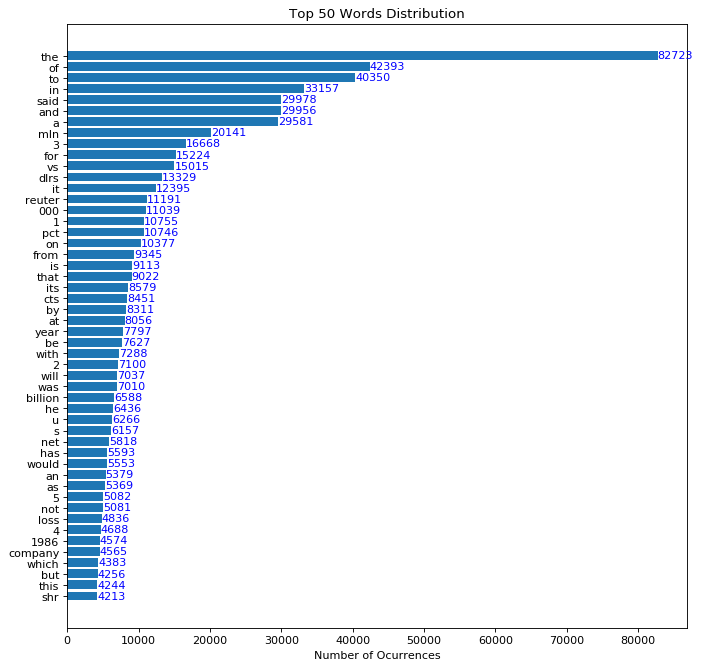

In [8]:
# Words Distribution

top = 50

words_with_repetition = []
for x in x_tot: 
    words_with_repetition.extend(x[1:])

x_hist, x_bin_edges =  np.histogram(words_with_repetition, bins=len(word_to_wordidx), range=(0,len(word_to_wordidx)-1))

sorted_num_of_ocurrences = np.sort(x_hist)[-top:]
sorted_words = [wordidx_to_word[key] for key in np.argsort(x_hist)[-top:]]

plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.barh(sorted_words, sorted_num_of_ocurrences, align='center')
plt.yticks(np.arange(top), sorted_words)
plt.xlabel('Number of Ocurrences')
plt.title('Top {} Words Distribution'.format(top))

ax = plt.gca()
for i, v in enumerate(sorted_num_of_ocurrences):
    ax.text(v + 3, i-0.25, str(v), color='blue')

plt.show()

In [34]:
num_sentences_with_label_in_it = 0

def count_num_sentences_with_label_in_it(x_tot):
    """
    Generator for counting number of sentences which contain the class word within the text
    
    Arguments:
    sample -- total dataset

    Returns:
    decode_newswire -- generator with True or False
    """
    for x in x_tot:
        words = [wordidx_to_word[wordidx] for wordidx in x]
        for label in classidx:
            yield (label in words)
                
num_sentences_with_label_in_it = np.sum(count_num_sentences_with_label_in_it(x_tot))

print('{:.2f}% of the examples have the label within the text.'.format(100*num_sentences_with_label_in_it/len(x_tot)))

63.35% of the examples have the label within the text.


### 1.3 - Data Filtering

In [10]:
top_classes = sorted_classes[-10:]
print("Top 10 most frequent classes: ", top_classes)
print("Dataset will now be filtered by those classes")
top_indexes = [classidx[label] for label in top_classes]
to_keep = [i for i,x in enumerate(y_tot) if x in top_indexes]
y_tot_filtered = y_tot[to_keep]
x_tot_filtered = x_tot[to_keep]
print('# of Samples kept: {}'.format(len(x_tot_filtered)))

Top 10 most frequent classes:  ['sugar', 'money-supply', 'ship', 'interest', 'trade', 'grain', 'crude', 'money-fx', 'acq', 'earn']
Dataset will now be filtered by those classes
# of Samples kept: 9509


In [11]:
print("We will only keep newswires with max 1000 words")
documents_word_lenght = [len (sample) for sample in x_tot_filtered]
to_keep = [idx for idx, value in enumerate(documents_word_lenght) if value <= 1000]
y_tot_filtered = y_tot_filtered[to_keep]
x_tot_filtered = x_tot_filtered[to_keep]
print('# of Samples kept: {}'.format(len(x_tot_filtered)))

We will only keep newswires with max 1000 words
# of Samples kept: 9504


### 1.4 - Pre-Processing

In [12]:
# Tokenizing
num_words_to_tokenize = len(word_to_wordidx)
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=num_words_to_tokenize)
x_tot_matrix = tokenizer.sequences_to_matrix(x_tot_filtered, mode='binary')
y_tot_categorical = keras.utils.to_categorical(y_tot_filtered, num_classes)
print ("When tokenizing the examples, we are just marking which words appear in the sentence. Therefore, we lose the information about the sequence itself, that is, the information which is implied in the order of the words.")

When tokenizing the examples, we are just marking which words appear in the sentence. Therefore, we lose the information about the sequence itself, that is, the information which is implied in the order of the words.


In [13]:
# Test Split
test_split = 0.1
test_num = round(len(x_tot_filtered)*test_split)
x_test_matrix = x_tot_matrix[:test_num]
x_test_seq = x_tot_filtered[:test_num]
x_train_matrix = x_tot_matrix[test_num:]
x_train_seq = x_tot_filtered[test_num:]
y_test_cat = y_tot_categorical[:test_num]
y_train_cat = y_tot_categorical[test_num:]
print ("We keep aside some examples for testing.")

We keep aside some examples for testing.


In [14]:
# Padding
documents_word_lenght = [len (sample) for sample in x_tot_filtered]
maxlen = np.max(documents_word_lenght)
x_train_pad = pad_sequences(x_train_seq, maxlen=maxlen)
x_test_pad =  pad_sequences(x_test_seq, maxlen=maxlen)
print ("Padding is for making all sequences of the same length, so we can then use them as inputs of neural networks.")

Padding is for making all sequences of the same length, so we can then use them as inputs of neural networks.


## Task 2

### 2.1 - Model 1:  Using tokenized input, one Full Connected Layer, and a Full Connected Layer for softmax
#### The idea here is just to make a model as simple as possible, just trying to guess the class from the words which appear in the sentence.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               15863296  
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 46)                23598     
Total params: 15,886,894
Trainable params: 15,886,894
Non-trainable params: 0
_________________________________________________________________
Train on 7698 samples, validate on 856 samples
Epoch 1/5
7698/7698 [==============================] - 43s 6ms/step - loss: 0.7805 - acc: 0.8122 - val_loss: 0.5564 - val_acc: 0.8692
Epoch 2/5
7698/7698 [==============================] - 44s 6ms/step - loss: 0.291

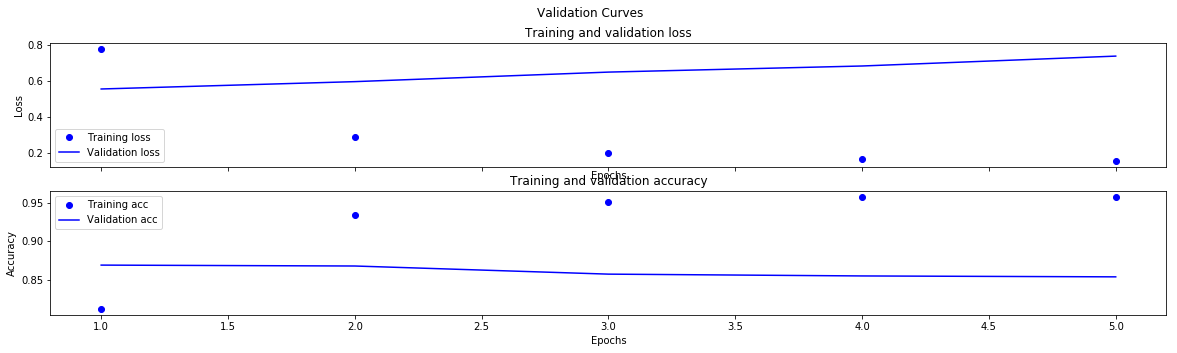

In [15]:
model = Sequential()
model.add(Dense(512, input_shape=(num_words_to_tokenize,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

batch_size = 32
epochs = 5
validation_split = 0.1

start = time.clock()
history = model.fit(x_train_matrix, y_train_cat, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=1, validation_split=validation_split)
end = time.clock()
print('Time spent:', end-start)
score = model.evaluate(x_test_matrix, y_test_cat, batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Validation Curves')
f.set_size_inches((20, 5))

# VALIDATION LOSS curves
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
ax1.plot(epochs, loss, 'bo', label='Training loss')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

## VALIDATION ACCURACY curves
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
ax2.plot(epochs, acc, 'bo', label='Training acc')
ax2.plot(epochs, val_acc, 'b', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

### 2.2 - Model 2:  Using padded input, an Embedded Layer, a Full Connected Layer, and another Full Connected Layer for softmax
#### One-hot encoded vectors are high-dimensional and sparse. So now we will use embeddings, where words are represented by dense vectors, and where a vector represents the projection of the word into a continuous vector space. The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used. 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 988, 32)           991424    
_________________________________________________________________
dropout_2 (Dropout)          (None, 988, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 31616)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               16187904  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 46)                23598     
Total params: 17,202,926
Trainable params: 17,202,926
Non-trainable params: 0
________________________________________________________________

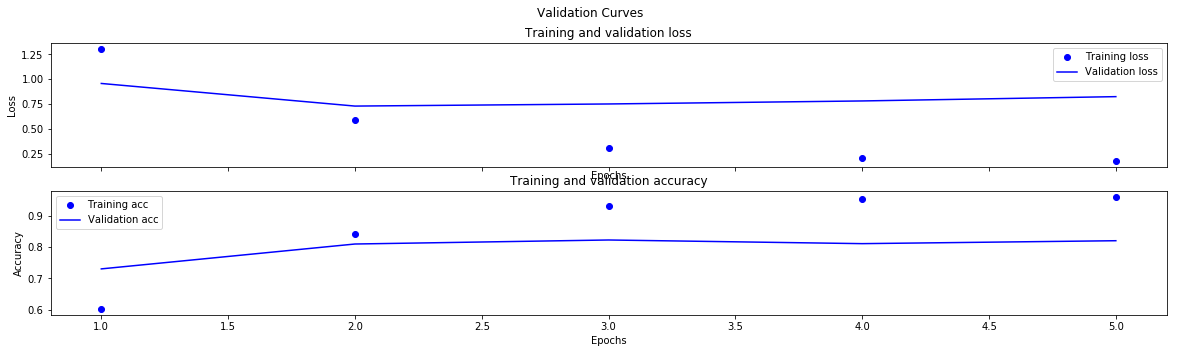

In [16]:
embedded_dim = 32
conv_filters = 32
conv_kernel = 3

model = Sequential()
model.add(Embedding(input_dim=len(word_to_wordidx), output_dim=embedded_dim, input_length=maxlen))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

batch_size = 32
epochs = 5
validation_split = 0.1

start = time.clock()
history = model.fit(x_train_pad, y_train_cat, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1, validation_split=validation_split)
end = time.clock()
print('Time spent:', end-start)
score = model.evaluate(x_test_pad, y_test_cat, batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Validation Curves')
f.set_size_inches((20, 5))

# VALIDATION LOSS curves
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
ax1.plot(epochs, loss, 'bo', label='Training loss')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

## VALIDATION ACCURACY curves
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
ax2.plot(epochs, acc, 'bo', label='Training acc')
ax2.plot(epochs, val_acc, 'b', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

### 2.3 - Model 3:  Using padded input, an Embedded Layer, a ConvLayer, a Full Connected Layer, and another Full Connected Layer for softmax
#### We add a Convolutional Layer to the last model, to convolve its kernel with the vectors after the embedding layer over a single spatial dimension. The idea here is to learn local associations between words, rather than having to rely on global associations.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 988, 32)           991424    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 988, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 494, 32)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 15808)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               8094208   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 46)                23598     
Total para

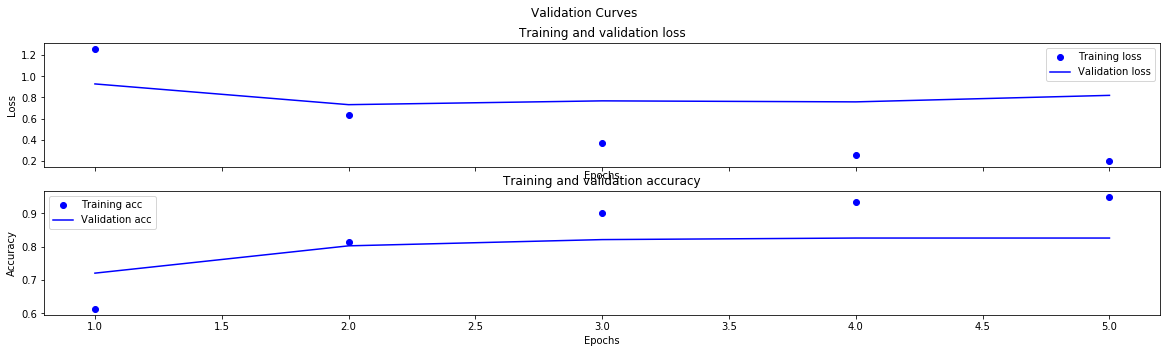

In [17]:
embedded_dim = 32
conv_filters = 32
conv_kernel = 3
pool_size=2

model = Sequential()
model.add(Embedding(input_dim=len(word_to_wordidx), output_dim=embedded_dim, input_length=maxlen))
model.add(Convolution1D(filters=conv_filters, kernel_size=conv_kernel, activation="relu", padding="same"))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

batch_size = 32
epochs = 5
validation_split = 0.1

start = time.clock()
history = model.fit(x_train_pad, y_train_cat, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1, validation_split=validation_split)
end = time.clock()
print('Time spent:', end-start)
score = model.evaluate(x_test_pad, y_test_cat, batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Validation Curves')
f.set_size_inches((20, 5))

# VALIDATION LOSS curves
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
ax1.plot(epochs, loss, 'bo', label='Training loss')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

## VALIDATION ACCURACY curves
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
ax2.plot(epochs, acc, 'bo', label='Training acc')
ax2.plot(epochs, val_acc, 'b', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

### 2.4 - Model 4:  Using padded input, a Pre-Trained Embedded Layer with GloVe, two LSTM layers, and Full Connected Layer for softmax
#### We will now add a pre-trained embedded layer with GloVe (donwload and unzip from here http://nlp.stanford.edu/data/glove.6B.zip), so we do not need to train those values, and moreover, it is supposed to work very well as it is already trained with larger datasets. We will also now use LSTM layers.

In [18]:
# We define two functions that will use later

def loadGloveModel(gloveFile):
    """
    Loads GloVe Model
    
    Arguments:
    gloveFile -- path to the glove file

    Returns:
    model -- a word_to_vec_map, where keys are words, and values are vectors (represented by arrays)
    """
    
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

def pretrained_embedding_layer(word_to_vec_map, word_to_wordidx):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_wordidx -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_wordidx) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros(((vocab_len, emb_dim)))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_wordidx.items():
        if word in word_to_vec_map:
            emb_matrix[index, :] = word_to_vec_map[word]
        else:
            emb_matrix[index, :] = word_to_vec_map["random"]  #just to set something when work is not in word_to_vec_map

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(input_dim=vocab_len, output_dim=emb_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [19]:
word_to_vec_map = loadGloveModel('glove.6B/glove.6B.50d.txt')

Loading Glove Model
Done. 400000  words loaded!


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 988)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 988, 50)           1549150   
_________________________________________________________________
lstm_1 (LSTM)                (None, 988, 32)           10624     
_________________________________________________________________
dropout_5 (Dropout)          (None, 988, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 46)                1518      
Total para

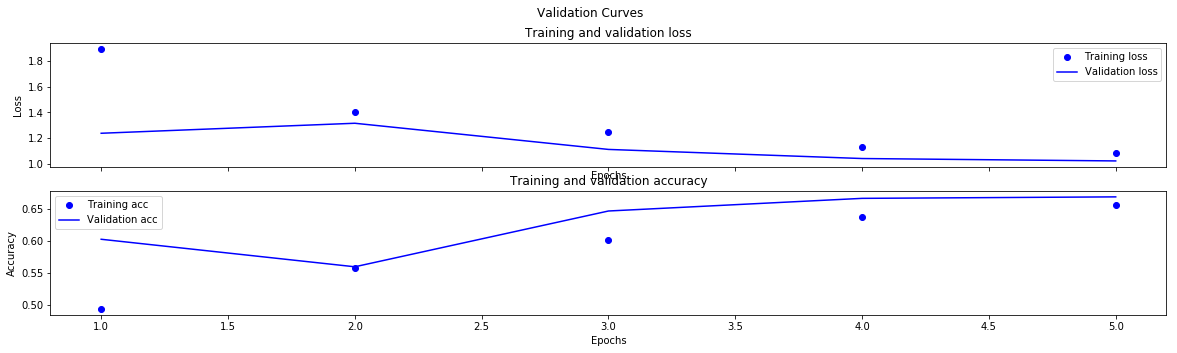

In [20]:

sentence_indices = Input(shape=(maxlen,), dtype='int32')
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_wordidx)
embeddings = embedding_layer(sentence_indices)
X = LSTM(32,return_sequences=True)(embeddings)
X = Dropout(0.5)(X)
X = LSTM(32,return_sequences=False)(X)
X = Dropout(0.5)(X)
X = Dense(num_classes, activation="softmax")(X)
model = Model(inputs = sentence_indices, outputs = X)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

batch_size = 32
epochs = 5
validation_split = 0.1

start = time.clock()
history = model.fit(x_train_pad, y_train_cat, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=1, validation_split=validation_split)
end = time.clock()
print('Time spent:', end-start)
score = model.evaluate(x_test_pad, y_test_cat, batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Validation Curves')
f.set_size_inches((20, 5))

# VALIDATION LOSS curves
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
ax1.plot(epochs, loss, 'bo', label='Training loss')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

## VALIDATION ACCURACY curves
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
ax2.plot(epochs, acc, 'bo', label='Training acc')
ax2.plot(epochs, val_acc, 'b', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

### 2.5 - Model 5:  Using padded input, a Pre-Trained Embedded Layer with GloVe, two Bidirectional LSTM layers, and Full Connected Layer for softmax
#### Now we will use bidirectional LSTM, so to learn a bit more from the association of words within a sentence

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 988)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 988, 50)           1549150   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 988, 64)           21248     
_________________________________________________________________
dropout_7 (Dropout)          (None, 988, 64)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 46)                2990      
Total para

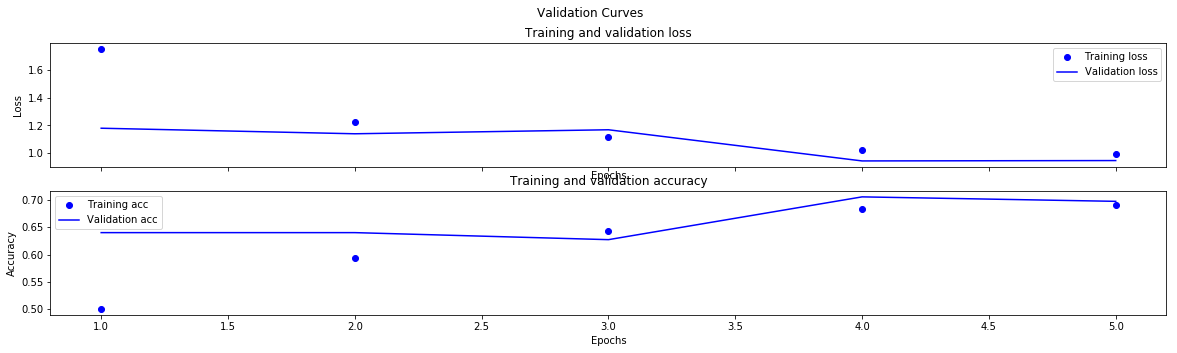

In [21]:

sentence_indices = Input(shape=(maxlen,), dtype='int32')
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_wordidx)
embeddings = embedding_layer(sentence_indices)
X = Bidirectional(LSTM(32,return_sequences=True))(embeddings)
X = Dropout(0.5)(X)
X = Bidirectional(LSTM(32,return_sequences=False))(X)
X = Dropout(0.5)(X)
X = Dense(num_classes, activation="softmax")(X)
model = Model(inputs = sentence_indices, outputs = X)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

batch_size = 32
epochs = 5
validation_split = 0.1

start = time.clock()
history = model.fit(x_train_pad, y_train_cat, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=1, validation_split=validation_split)
end = time.clock()
print('Time spent:', end-start)
score = model.evaluate(x_test_pad, y_test_cat, batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Validation Curves')
f.set_size_inches((20, 5))

# VALIDATION LOSS curves
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
ax1.plot(epochs, loss, 'bo', label='Training loss')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

## VALIDATION ACCURACY curves
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
ax2.plot(epochs, acc, 'bo', label='Training acc')
ax2.plot(epochs, val_acc, 'b', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

## Task 3

### 3.1 - One approach could be to transform whole sequences to vectors, using the information of the word_to_vec_map. Here, we compute the mean of the words in one sentence, to get a vector that represents each sentence. Then, we compute the mean of all these vectors in the training set, and the cosine similarity of each vector to the mean vector. Using the mean and std of the cosine similarities, we define a threshold that we could use to estimate if a given sentence is different from what was seen during the training. This model should reject sentences with words different from the training set, but it could probably not reject some random sentences with  words used in the training set.

In [22]:
# We define two functions that will use later

def seq_to_vec(seq, word_to_vec_map):
    """
    Sequence to vector
    
    Arguments:
    seq -- a sequence sample of the train set
    word_to_vec_map -- output of loadGloveModel

    Returns:
    mean_vec_for_seq -- The mean of all vectors corresponding to each word in the sequence
    """    
    
    vec = (word_to_vec_map[wordidx_to_word[wordidx]]
                 if wordidx_to_word[wordidx] in word_to_vec_map
                 else
                 np.zeros((len(list(word_to_vec_map.values())[0])))
                 for wordidx in seq )
    
    mean_vec_for_seq = np.sum(vec,0) / len(seq)
    
    return mean_vec_for_seq

def cosine_similarity(u, v):
    """
    Cosine similarity reflects the degree of similariy between u and v
        
    Arguments:
        u -- a word vector of shape (n,)          
        v -- a word vector of shape (n,)

    Returns:
        cosine_similarity -- the cosine similarity between u and v defined by the formula above.
    """
    
    distance = 0.0
    dot = np.dot(u,v)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    cosine_similarity = dot/(norm_u*norm_v)    
    return cosine_similarity

def check_rejection(distance, mean_cosine_similarity, std_cosine_similarity, std_threshold):
    if (( distance > mean_cosine_similarity+std_threshold*std_cosine_similarity )
        or ( distance < mean_cosine_similarity-std_threshold*std_cosine_similarity )):
        print("Rejected")
    else:
        print("Accepted")
    return

In [23]:
gen_acum_vec = (seq_to_vec(seq, word_to_vec_map) for seq in x_train_seq)
sentences_vec_acum = np.sum(gen_acum_vec,0)
sentences_vec_mean = sentences_vec_acum / len(x_train_seq)
cosine_similarity_list = [ cosine_similarity(seq_to_vec(seq, word_to_vec_map), sentences_vec_mean)
              for seq in x_train_seq ]

In [24]:
mean_cosine_similarity = np.mean(cosine_similarity_list)
std_cosine_similarity = np.std(cosine_similarity_list)
print('Mean of cosine similarity {}'.format(mean_cosine_similarity))
print('Std of cosine similarity {}'.format(std_cosine_similarity))

Mean of cosine similarity 0.920536635860029
Std of cosine similarity 0.07099602709762694


In [25]:
# Devaiation threshold to use
std_threshold = 1.0

In [26]:
# Check if it rejects or accepts an actual sentence of the training
example = 123
distance = cosine_similarity(seq_to_vec(x_train_seq[example], word_to_vec_map), sentences_vec_mean)
check_rejection(distance, mean_cosine_similarity, std_cosine_similarity, std_threshold)

Accepted


In [27]:
# Check if it rejects or accepts random sentences, but with words of the training set
random_seq = [123, 1546, 3587, 2671, 189, 36, 875, 124]
distance = cosine_similarity(seq_to_vec(random_seq, word_to_vec_map), sentences_vec_mean)
check_rejection(distance, mean_cosine_similarity, std_cosine_similarity, std_threshold)

random_seq = [1546, 123, 124, 875, 2671, 36, 3587, 189, 7574, 45, 77, 2457]
distance = cosine_similarity(seq_to_vec(random_seq, word_to_vec_map), sentences_vec_mean)
check_rejection(distance, mean_cosine_similarity, std_cosine_similarity, std_threshold)

random_seq = [123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123]
distance = cosine_similarity(seq_to_vec(random_seq, word_to_vec_map), sentences_vec_mean)
check_rejection(distance, mean_cosine_similarity, std_cosine_similarity, std_threshold)

Accepted
Accepted
Accepted


In [28]:
# Check if it rejects or accepts random sentences, with words from an open set
random_sentence = "this is a random sentence to test the algorithm"
random_sentence_splitted = random_sentence.replace(',',' ').split()
vec = [word_to_vec_map[word] for word in random_sentence_splitted]
mean_vec_for_seq = np.sum(vec,0) / len(random_sentence_splitted)
distance = cosine_similarity(mean_vec_for_seq, sentences_vec_mean)
check_rejection(distance, mean_cosine_similarity, std_cosine_similarity, std_threshold)

random_sentence = "if we create a document by putting random words together, this document must be rejected"
random_sentence_splitted = random_sentence.replace(',',' ').split()
vec = [word_to_vec_map[word] for word in random_sentence_splitted]
mean_vec_for_seq = np.sum(vec,0) / len(random_sentence_splitted)
distance = cosine_similarity(mean_vec_for_seq, sentences_vec_mean)
check_rejection(distance, mean_cosine_similarity, std_cosine_similarity, std_threshold)

Rejected
Rejected


### 3.2 - Other approach could be to output the logits instead of the softmax layer of a trained model, and try to estimate if the given sentence comes from the same distribution as the training set, or from a different one. Another approach could be to train another model, adding one more class, for sentences not in this dataset, but from other datasets, or randomly generated from other dictionaries.



## Task 4

### 4.1 - Point-wise mutual information
#### Given two words, we will count the ocurrences those words, and the bigram, in the set. Finally we compute the PMI using the formula in en.wikipedia.org/wiki/Pointwise_mutual_information

In [29]:
def compute_pmi(word_1,word_2, x_tot, word_to_wordidx):
    
    if ((word_1 in word_to_wordidx) and (word_2 in word_to_wordidx)):
        words_with_repetition = []
        for x in x_tot: 
            words_with_repetition.extend(x[1:])
        x_hist, x_bin_edges =  np.histogram(words_with_repetition, bins=len(word_to_wordidx), range=(0,len(word_to_wordidx)-1))

        count_word_1 = x_hist[word_to_wordidx[word_1]]
        count_word_2 = x_hist[word_to_wordidx[word_2]]
        co_occurrences = (True for x in x_tot for i in range(len(x)-1) if (word_to_wordidx[word_1], word_to_wordidx[word_2])==(x[i],x[i+1]))
        count_co_occurrences = np.sum(co_occurrences)
        
        if (count_co_occurrences):
            pmi = np.log(len(words_with_repetition) * count_co_occurrences / (count_word_1 * count_word_2))
            return pmi
        else:
            print ("No co-ocurrences found")
        
    elif word_1 not in word_to_wordidx:
        print ("{} is not in the dictionary".format(word_1))
    elif word_2 not in word_to_wordidx:
        print ("{} is not in the dictionary".format(word_2))  
    

In [30]:
compute_pmi("buenos","aires", x_tot, word_to_wordidx)

10.806145168299496

In [31]:
compute_pmi("in","at", x_tot, word_to_wordidx)

-3.1546186902873212

In [32]:
compute_pmi("buenos","at", x_tot, word_to_wordidx)

No co-ocurrences found


### 4.2 - Bigrams statistics
#### I compute the top 20 bigrams

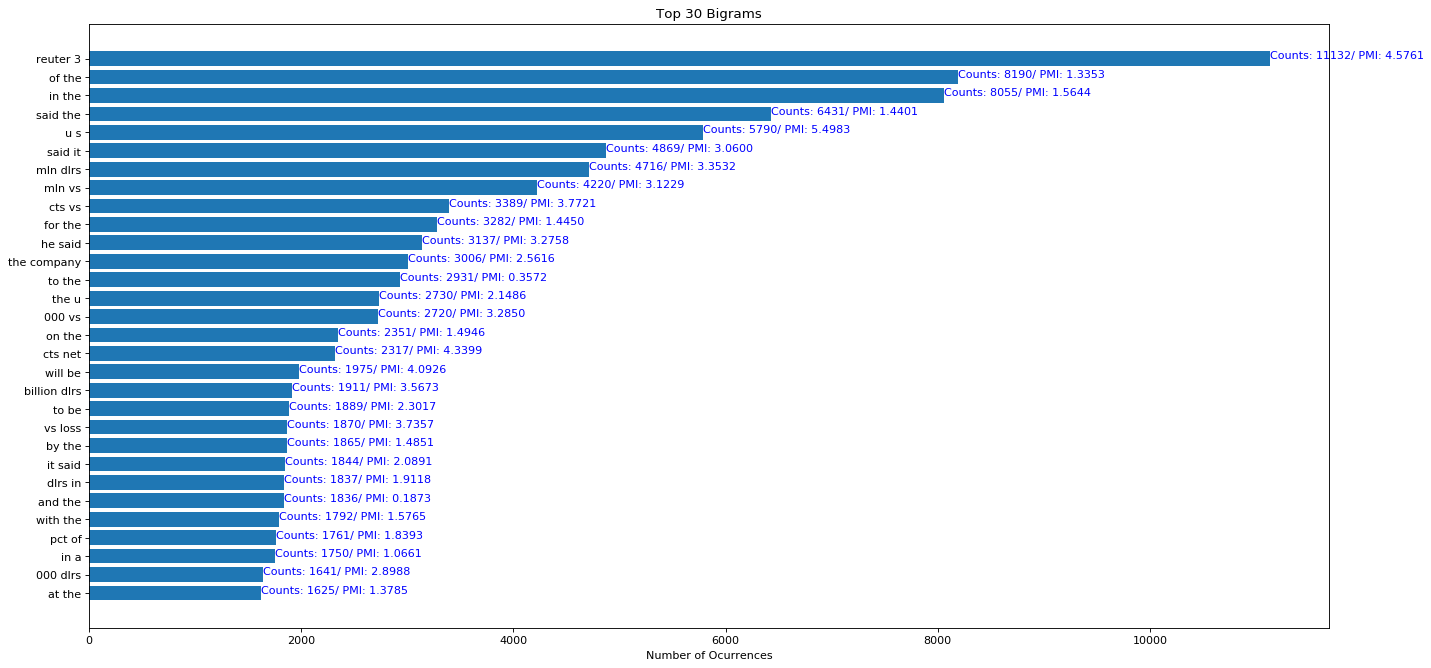

In [33]:
top_bigrams_num = 30
bigrams = [(x[i],x[i+1]) for x in x_tot for i in range(1,len(x)-1)] # I skip <START> character
counter = collections.Counter(bigrams)
most_commons = [most_common for most_common in counter.most_common(top_bigrams_num)]
encoded_bigrams = [most_common[0] for most_common in most_commons]
decoded_bigrams = [decode_newswire(most_common[0]) for most_common in most_commons]
bigrams_counts = [most_common[1] for most_common in most_commons]
bigrams_pmi = [compute_pmi(wordidx_to_word[encoded_bigram[0]],wordidx_to_word[encoded_bigram[1]], x_tot, word_to_wordidx) for encoded_bigram in encoded_bigrams]

plt.figure(num=None, figsize=(20, 10), dpi=80)
plt.barh(decoded_bigrams, bigrams_counts, align='center')
plt.yticks(np.arange(top_bigrams_num), decoded_bigrams)
plt.xlabel('Number of Ocurrences')
plt.title('Top {} Bigrams'.format(top_bigrams_num))

plt.gca().invert_yaxis()
ax = plt.gca()
for i, v in enumerate(bigrams_counts):
    ax.text(v , i, "Counts: " + str(v) + "/ PMI: " + "{:2.4f}".format(bigrams_pmi[i]), color='blue')

plt.show()